In [2]:
import pandas_datareader.data as web
import datetime as dt 
import pandas as pd 
import matplotlib.pyplot as plt 
from arch import arch_model 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA 
import numpy as np
import itertools 
from sklearn.metrics import mean_squared_error
import warnings 
warnings.filterwarnings('ignore')

# 1) Load the Data

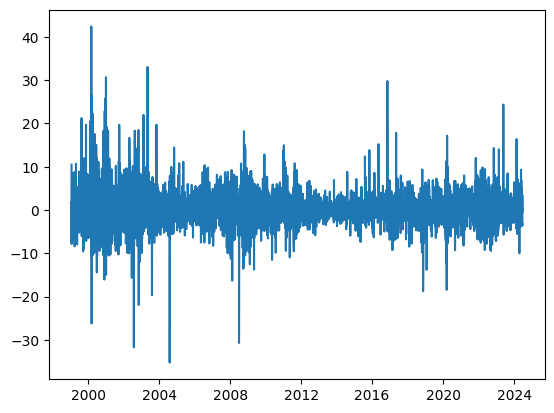

In [2]:
df = pd.read_csv('NVDA.csv')
df = df[['Date','Close']] # take relevant data
df['Date']
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return dt.datetime(year=year,month=month,day=day)

datetime_obj = str_to_datetime('1999-01-22')

df['Date'] = df['Date'].apply(str_to_datetime) # Turn dates into datetime objects (not strings)
df.index = df.pop('Date')
returns = 100*df['Close'].pct_change().dropna()
plt.plot(returns) # good candidate for GARCH because volatility changes over time

# 2) Fit a GARCH Model

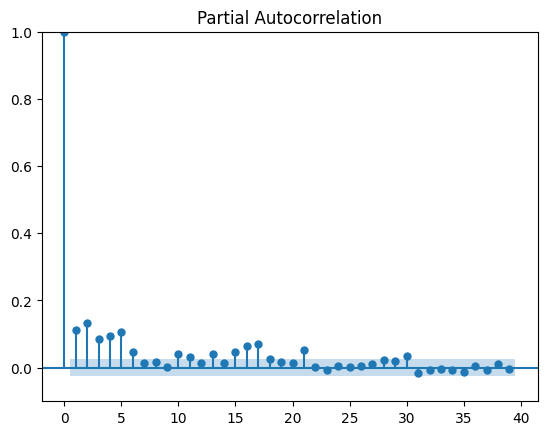

In [3]:
fig, ax = plt.subplots()
plot_pacf(returns**2,ax=ax)
ax.set_ylim(-0.1,1)
plt.show()

In [4]:
model = arch_model(returns,p=1,q=1)
model_fit = model.fit()
model_fit.summary

Iteration:      1,   Func. Count:      6,   Neg. LLF: 46632.13791804343
Iteration:      2,   Func. Count:     16,   Neg. LLF: 64828641687.79334
Iteration:      3,   Func. Count:     24,   Neg. LLF: 59058698.70378072
Iteration:      4,   Func. Count:     30,   Neg. LLF: 16836.529474980336
Iteration:      5,   Func. Count:     36,   Neg. LLF: 16709.396943628555
Iteration:      6,   Func. Count:     41,   Neg. LLF: 34366.30611894364
Iteration:      7,   Func. Count:     47,   Neg. LLF: 17756.836524704602
Iteration:      8,   Func. Count:     56,   Neg. LLF: 23164.068091502253
Iteration:      9,   Func. Count:     62,   Neg. LLF: 16704.06314815948
Iteration:     10,   Func. Count:     67,   Neg. LLF: 16703.67579966765
Iteration:     11,   Func. Count:     72,   Neg. LLF: 16703.635284082105
Iteration:     12,   Func. Count:     77,   Neg. LLF: 16703.63405367086
Iteration:     13,   Func. Count:     82,   Neg. LLF: 16703.633989142523
Iteration:     14,   Func. Count:     87,   Neg. LLF: 1670

<bound method ARCHModelResult.summary of                      Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -16703.6
Distribution:                  Normal   AIC:                           33415.3
Method:            Maximum Likelihood   BIC:                           33442.3
                                        No. Observations:                 6394
Date:                Mon, Jun 24 2024   Df Residuals:                     6393
Time:                        15:35:07   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2335  5.268e

In [5]:
rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = returns[:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

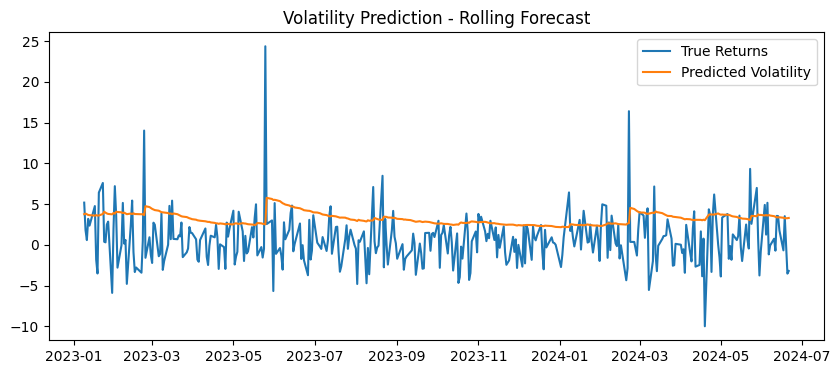

In [6]:
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-365:])

plt.figure(figsize=(10,4))
true, = plt.plot(returns[-365:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast')
plt.legend(['True Returns','Predicted Volatility'])

In [7]:
### Using the Model ###

train = returns 
model = arch_model(train, p=1,q=1)
model_fit = model.fit(disp='off')

pred = model_fit.forecast(horizon=7)
future_dates = [returns.index[-1] + dt.timedelta(days=i) for i in range(1,8)]
pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=future_dates)

Text(0.5, 1.0, 'Volatility Prediction - Next 7 Days')

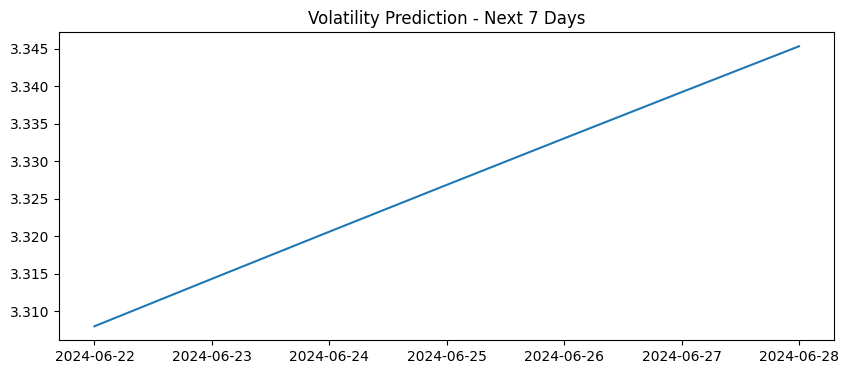

In [8]:
plt.figure(figsize=(10,4))
plt.plot(pred)
plt.title('Volatility Prediction - Next 7 Days')

# 3) Fit an ARIMA Model 

In [9]:
price = df['Close']
price.describe()

count    6395.000000
mean        5.735178
std        14.335830
min         0.034115
25%         0.275750
50%         0.455750
75%         4.123375
max       135.580002
Name: Close, dtype: float64

## Determine d param
Number of differencing required to achieve stationarity: 1

In [10]:
# ADF Test for stationarity 
result = adfuller(price.dropna())
print(f"ADF Stat: {result[0]}")
print(f"P-Value: {result[1]}") # clearly, NVDA is not stationary

ADF Stat: 8.618906693214436
P-Value: 1.0


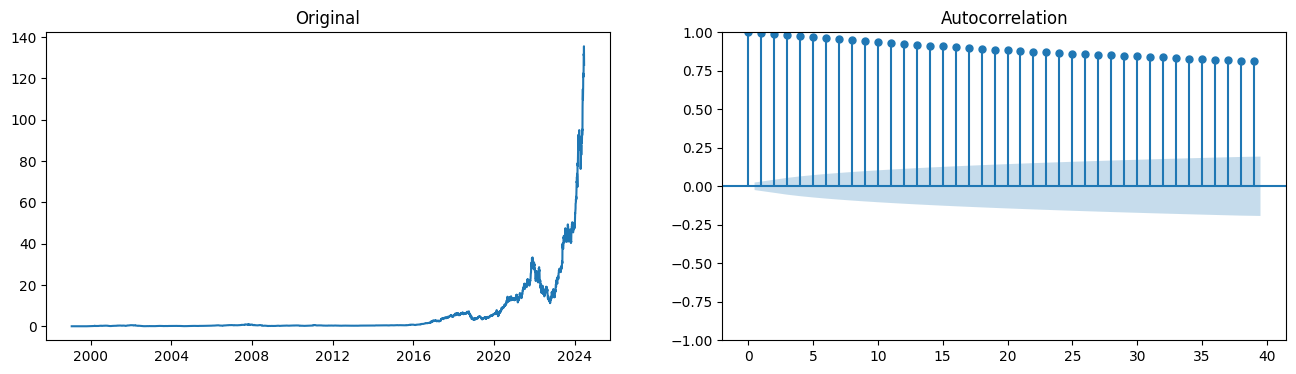

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(price)
ax1.set_title("Original")
plot_acf(price, ax=ax2);

(-0.25, 1.0)

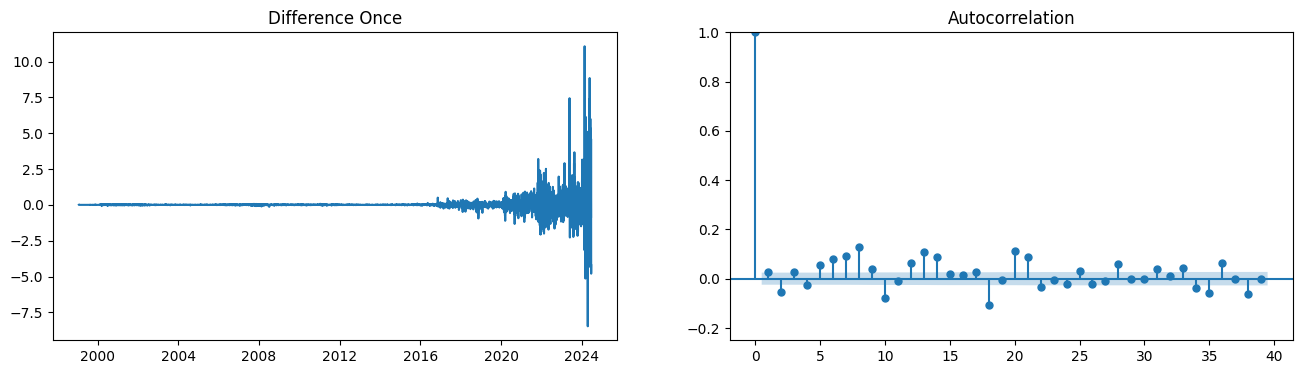

In [12]:
diff = price.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference Once")
plot_acf(diff, ax=ax2);
ax2.set_ylim(-0.25,1)

## Determine p param
Q: first autocorrelation lag that is outside of the acf range: 3

P: first autocorrelation lag that is outside of the pacf range: 3 

(-0.25, 1.0)

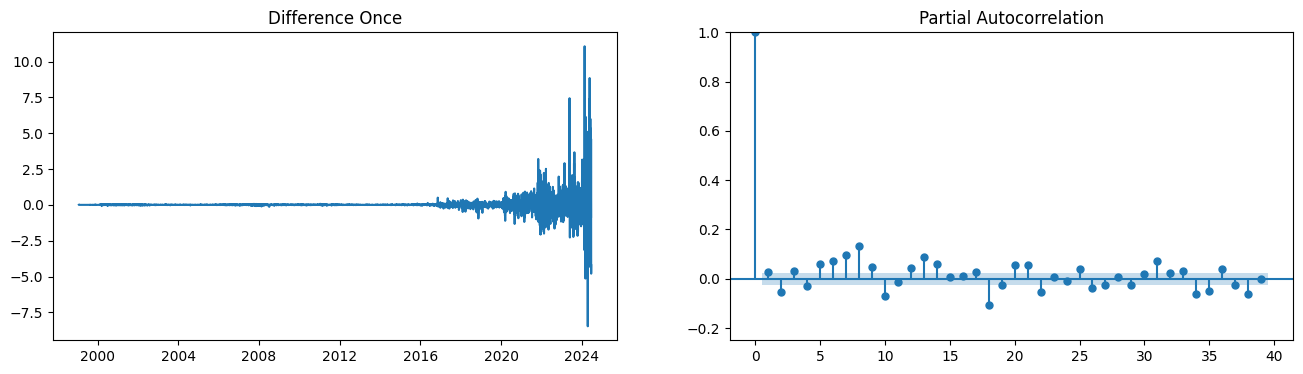

In [94]:
diff = price.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference Once")
plot_pacf(diff, ax=ax2);
ax2.set_ylim(-0.25,1)

In [14]:
mdl_arima = ARIMA(price, order=(3,1,3))
mdl_arima_fit = mdl_arima.fit()
mdl_arima_fit.summary()

C:\Users\shristov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\shristov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\shristov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 6395
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -4355.831
Date:                Mon, 24 Jun 2024   AIC                           8725.661
Time:                        15:35:47   BIC                           8773.003
Sample:                             0   HQIC                          8742.049
                               - 6395                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6936      0.013     52.095      0.000       0.668       0.720
ar.L2          0.9761      0.005    207.730      0.000       0.967       0.985
ar.L3         -0.7139      0.014    -52.724      0.000      -0.740      -0.687
ma.L1         -0.7416      0.013    -57.768      0.000      -0.767      -0.716
ma.L2         -0.9621      0.006   -153.991      0.000      -0.974      -0.950
ma.L3          0.7790      0.013     60.783      0.000       0.754       0.804
sigma2         0.2286      0.001    354.548      0.000       0.227       0.230
===================================================================================
Ljung-Box (L1) (Q):                  14.21   Jarque-Bera (JB):           3316402.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):            5291.01   Skew:                             3.45
Prob(H) (two-sided):                  0.00   Kurtosis:                       114.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(array([8.31741240e-05, 3.32696496e-04, 4.15870620e-04, 1.15612032e-02,
        5.11687211e-01, 5.90536280e-03, 1.33078598e-03, 2.49522372e-04,
        2.49522372e-04, 8.31741240e-05]),
 array([-8.29868163, -6.41862376, -4.5385659 , -2.65850804, -0.77845017,
         1.10160769,  2.98166555,  4.86172342,  6.74178128,  8.62183914,
        10.50189701]),
 <BarContainer object of 10 artists>)

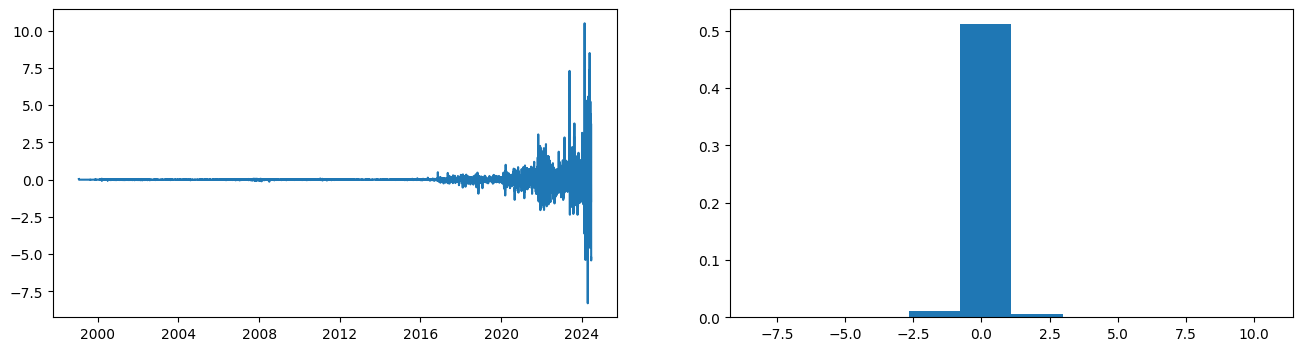

In [15]:
residuals = pd.DataFrame(mdl_arima_fit.resid)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.plot(residuals)
ax2.hist(residuals, density=True)

C:\Users\shristov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\shristov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


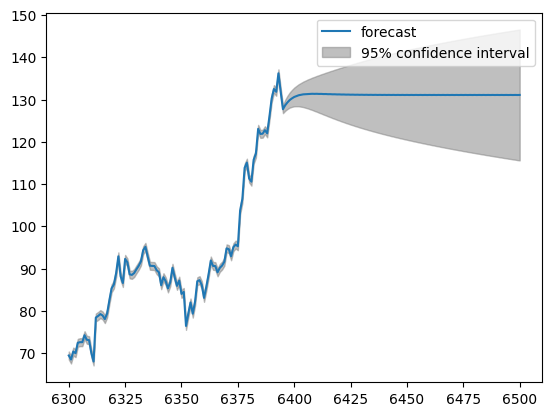

In [16]:
plot_predict(mdl_arima_fit,
    start = 6300, 
    end = 6500,
    dynamic = False
);

# 1) Load Data

In [3]:
df = pd.read_csv('NVDA.csv')
df = df[['Date','Close']] # take relevant data
df['Date']
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return dt.datetime(year=year,month=month,day=day)

datetime_obj = str_to_datetime('1999-01-22')

df['Date'] = df['Date'].apply(str_to_datetime)
df.set_index('Date',inplace=True)

train_size = int(len(df)*0.8)
val_size = int(len(df)*0.1)
test_size = len(df) - train_size - val_size

train, val, test = df[:train_size], df[train_size: train_size+val_size], df[train_size+val_size:]

In [15]:
def check_stationarity(series): 
    result = adfuller(series) 
    return result[1] < 0.05 # indicates stationarity 

def difference_if_needed(series):
    if not check_stationarity(series['Close']):
        series_diff = series['Close'].diff().dropna() 
    else: 
        series_diff = series['Close']
    return series_diff 

train_diff = difference_if_needed(train)
val_diff = difference_if_needed(val)


0.004297000000000002

# 2) Fit ARIMA

In [18]:
# ARIMA Grid Search 
p = d = q = range(0,5)
pdq = list(itertools.product(p,d,q))

print("pdq list complete, beginning grid search")

best_aic = np.inf 
best_order = None 
best_mse = np.inf 
for param in pdq: 
    try: 
        model_arima = ARIMA(train_diff, order=param)
        model_arima_fit = model_arima.fit() 

        predictions = model_arima_fit.forecast(steps=len(val))
        mse = mean_squared_error(val_diff, predictions[:len(val_diff)])  
        if mse < best_mse: 
            best_mse = mse 
            best_order = param 
        print(f'Tried order: {param} with MSE: {best_mse}')
    except Exception as e: 
        print(f"Error with order {param}: {e}")                                        

print(f"Best ARIMA order: {best_order} with MSE: {best_mse}")

pdq list complete, beginning grid search
Tried order: (0, 0, 0) with MSE: 0.1507006387303876
Tried order: (0, 0, 1) with MSE: 0.1507006387303876
Tried order: (0, 0, 2) with MSE: 0.1507006387303876
Tried order: (0, 0, 3) with MSE: 0.15069980606395078
Tried order: (0, 0, 4) with MSE: 0.1506994233514186
Tried order: (0, 1, 0) with MSE: 0.1506994233514186
Tried order: (0, 1, 1) with MSE: 0.15067758417246913
Tried order: (0, 1, 2) with MSE: 0.15067758417246913
Tried order: (0, 1, 3) with MSE: 0.15066881331483098
Tried order: (0, 1, 4) with MSE: 0.15066881331483098
Tried order: (0, 2, 0) with MSE: 0.15066881331483098
Tried order: (0, 2, 1) with MSE: 0.15066881331483098
Tried order: (0, 2, 2) with MSE: 0.15066881331483098
Tried order: (0, 2, 3) with MSE: 0.15066881331483098
Tried order: (0, 2, 4) with MSE: 0.15066881331483098
Tried order: (0, 3, 0) with MSE: 0.15066881331483098
Tried order: (0, 3, 1) with MSE: 0.15066881331483098
Tried order: (0, 3, 2) with MSE: 0.15066881331483098
Tried orde

In [29]:
model_arima = ARIMA(train['Close'], order=(1,1,2))
model_arima_fit = model_arima.fit()

arima_pred = model_arima_fit.forecast(steps=1)
residuals = model_arima_fit.resid

In [33]:
model_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 5116
Model:                 ARIMA(1, 1, 2)   Log Likelihood                8339.733
Date:                Mon, 24 Jun 2024   AIC                         -16671.466
Time:                        18:07:45   BIC                         -16645.306
Sample:                             0   HQIC                        -16662.308
                               - 5116                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4818      0.080      6.003      0.000       0.325       0.639
ma.L1         -0.5217      0.081     -6.468      0.000      -0.680      -0.364
ma.L2          0.0551      0.004     12.265      0.000       0.046       0.064
sigma2         0.0022   7.98e-06    281.288      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            894088.74
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              53.86   Skew:                            -2.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        67.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 3) Fit GARCH

In [40]:
residuals.iloc[-len(val_diff):]

Date
2016-11-07    0.093362
2016-11-08    0.001907
2016-11-09   -0.032829
2016-11-10   -0.057529
2016-11-11    0.503175
                ...   
2019-05-16    0.015605
2019-05-17   -0.088095
2019-05-20   -0.122237
2019-05-21    0.081409
2019-05-22   -0.062155
Name: None, Length: 638, dtype: float64

In [41]:
# GARCH Grid Search 
p = q = range(1,5)
pq = list(itertools.product(p,q))
res_val = residuals.iloc[-len(val_diff):]

print("pdq list complete, beginning grid search")

best_order = None 
best_mse = np.inf 
for param in pq: 
    try: 
        model_garch = arch_model(res_val, vol='Garch', p = param[0], q = param[1])
        model_garch_fit = model_garch.fit(disp='off') 

        predictions = model_garch_fit.forecast(horizon=len(val_diff))
        forecast_variance = predictions.variance.values[-1,:] # last forecasted variance

        mse = mean_squared_error(val_diff, forecast_variance)  
        if mse < best_mse: 
            best_mse = mse 
            best_order = param 
        print(f'Tried order: {param} with MSE: {best_mse}')
    except Exception as e: 
        print(f"Error with order {param}: {e}")                                        

print(f"Best GARCH order: {best_order} with MSE: {best_mse}")

pdq list complete, beginning grid search
Tried order: (1, 1) with MSE: 0.14945308202528293
Tried order: (1, 2) with MSE: 0.14945308202528293
Tried order: (1, 3) with MSE: 0.14945308202528293
Tried order: (1, 4) with MSE: 0.14945308202528293
Tried order: (2, 1) with MSE: 0.14945308202528293
Tried order: (2, 2) with MSE: 0.14937245567423355
Tried order: (2, 3) with MSE: 0.14937245567423355
Tried order: (2, 4) with MSE: 0.14937245567423355
Tried order: (3, 1) with MSE: 0.14937245567423355
Tried order: (3, 2) with MSE: 0.14937245567423355
Tried order: (3, 3) with MSE: 0.14937245567423355
Tried order: (3, 4) with MSE: 0.14937245567423355
Tried order: (4, 1) with MSE: 0.14937245567423355
Tried order: (4, 2) with MSE: 0.14937245567423355
Tried order: (4, 3) with MSE: 0.14937245567423355
Tried order: (4, 4) with MSE: 0.14937245567423355
Best GARCH order: (2, 2) with MSE: 0.14937245567423355


In [66]:
# fit GARCH model 
model_garch = arch_model(residuals, vol='Garch', p=2, q=2)
model_garch_fit = model_garch.fit(disp='off')

# GARCH predictions 
garch_pred = model_garch_fit.forecast(horizon=1)
garch_pred_var = garch_pred.variance.iloc[-1,0]

garch_pred_var

0.0089363596125361

# 4) Combine ARIMA and GARCH models

In [77]:
arima_garch_upper = arima_pred + np.sqrt(garch_pred_var)
arima_garch_lower = arima_pred - np.sqrt(garch_pred_var)

print("ARIMA Prediction (Next Day):", arima_pred)
print("GARCH Prediction (Next Day Variance):", garch_pred_var)
print("ARIMA-GARCH Prediction (Next Day Price Interval):", arima_garch_lower.iloc[0], "to", arima_garch_upper.iloc[0])

ARIMA Prediction (Next Day): 5116    3.798982
dtype: float64
GARCH Prediction (Next Day Variance): 0.0089363596125361
ARIMA-GARCH Prediction (Next Day Price Interval): 3.704449795263325 to 3.8935144361937333


In [86]:
arima_garch_lower.iloc[0]
arima_garch_upper.iloc[0]

3.8935144361937333

# 5) Forecast

In [75]:
### NOMINAL FORECAST ### 
days_forecast = 365 

model_arima = ARIMA(train['Close'], order=(1,1,2))
model_arima_fit = model_arima.fit() 

arima_pred = model_arima_fit.forecast(steps=days_forecast) 

residuals = model_arima_fit.resid

model_garch = arch_model(residuals, vol='Garch', p=2, q=2)
model_garch_fit = model_garch.fit(disp='off')

garch_pred = model_garch_fit.forecast(horizon=days_forecast)
garch_pred_var = garch_pred.variance.iloc[-1,0]
garch_pred_std = np.sqrt(garch_pred_var)

next_day_pred_upper = arima_pred + garch_pred_std 
next_day_pred_lower = arima_pred - garch_pred_std 

predictions = arima_pred
lower_bounds = next_day_pred_lower
upper_bounds = next_day_pred_upper 

In [76]:
predictions.values

array([3.80746834, 3.80523009, 3.80415169, 3.80363212, 3.80338179,
       3.80326118, 3.80320307, 3.80317507, 3.80316158, 3.80315508,
       3.80315195, 3.80315044, 3.80314972, 3.80314937, 3.8031492 ,
       3.80314912, 3.80314908, 3.80314906, 3.80314905, 3.80314904,
       3.80314904, 3.80314904, 3.80314904, 3.80314904, 3.80314904,
       3.80314904, 3.80314904, 3.80314904, 3.80314904, 3.80314904,
       3.80314904, 3.80314904, 3.80314904, 3.80314904, 3.80314904,
       3.80314904, 3.80314904, 3.80314904, 3.80314904, 3.80314904,
       3.80314904, 3.80314904, 3.80314904, 3.80314904, 3.80314904,
       3.80314904, 3.80314904, 3.80314904, 3.80314904, 3.80314904,
       3.80314904, 3.80314904, 3.80314904, 3.80314904, 3.80314904,
       3.80314904, 3.80314904, 3.80314904, 3.80314904, 3.80314904,
       3.80314904, 3.80314904, 3.80314904, 3.80314904, 3.80314904,
       3.80314904, 3.80314904, 3.80314904, 3.80314904, 3.80314904,
       3.80314904, 3.80314904, 3.80314904, 3.80314904, 3.80314

In [78]:
forecast_dates = pd.date_range(start=val.index[0], periods=365, freq='B')  # Adjust frequency as needed
forecast_df = pd.DataFrame({
    'Predictions': predictions.values,
    'Lower Bound': lower_bounds.values,
    'Upper Bound': upper_bounds.values
}, index=forecast_dates)

forecast_df

,Predictions,Lower Bound,Upper Bound
2019-05-23,3.807468,3.712940,3.901997
2019-05-24,3.805230,3.710702,3.899758
2019-05-27,3.804152,3.709623,3.898680
2019-05-28,3.803632,3.709104,3.898160
2019-05-29,3.803382,3.708854,3.897910
...,...,...,...
2020-10-08,3.803149,3.708621,3.897677
2020-10-09,3.803149,3.708621,3.897677
2020-10-12,3.803149,3.708621,3.897677
2020-10-13,3.803149,3.708621,3.897677


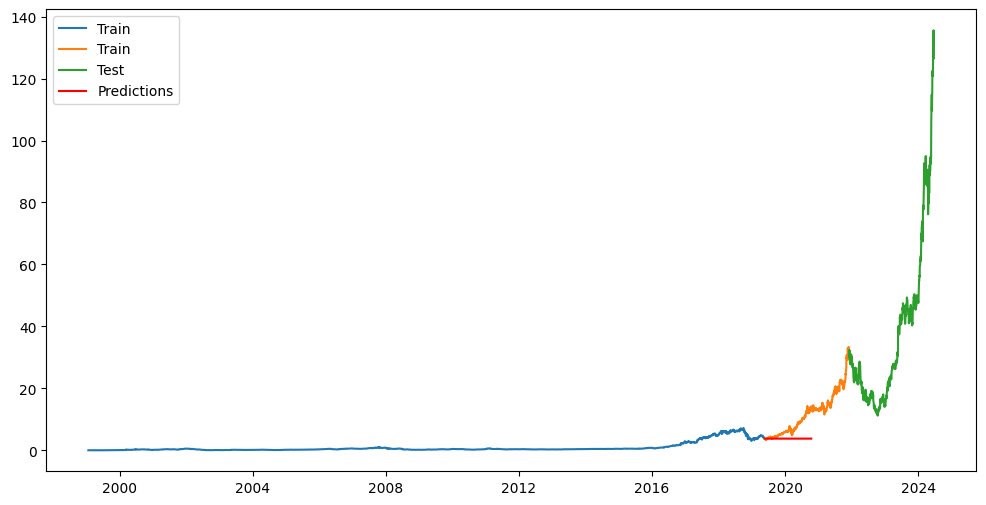

In [79]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(val.index, val['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test')

plt.plot(forecast_df.index, forecast_df['Predictions'], label='Predictions', color='r')
plt.fill_between(forecast_df.index, forecast_df['Lower Bound'], forecast_df['Upper Bound'], color='pink', alpha=0.3)
plt.legend(loc='upper left')
plt.show()

In [80]:
### RECURSIVE FORECAST ###

predictions = []
lower_bounds = []
upper_bounds = []


history = pd.concat([train['Close'], val['Close']])

for t in range(len(test)): 
    try: 
        model_arima = ARIMA(history, order=(1,1,2))
        model_arima_fit = model_arima.fit() 

        arima_pred = model_arima_fit.forecast(steps=1).iloc[0] 

        residuals = model_arima_fit.resid

        model_garch = arch_model(residuals, vol='Garch', p=2, q=2)
        model_garch_fit = model_garch.fit(disp='off')

        garch_pred = model_garch_fit.forecast(horizon=1)
        garch_pred_var = garch_pred.variance.iloc[-1,0]
        garch_pred_std = np.sqrt(garch_pred_var)

        next_day_pred_upper = arima_pred + garch_pred_std 
        next_day_pred_lower = arima_pred - garch_pred_std 

        predictions.append(arima_pred)
        lower_bounds.append(next_day_pred_upper)
        upper_bounds.append(next_day_pred_lower)

        print(f"Trained model {t} out of {len(test)}")
    except Exception as e: 
        print(f"Error at step {t}: {e}")
    
    history = pd.concat([history, pd.Series(test['Close'].iloc[t], index=[test.index[t]])])


Trained model 0 out of 640
Trained model 1 out of 640
Trained model 2 out of 640
Trained model 3 out of 640
Trained model 4 out of 640
Trained model 5 out of 640
Trained model 6 out of 640
Trained model 7 out of 640
Trained model 8 out of 640
Trained model 9 out of 640
Trained model 10 out of 640
Trained model 11 out of 640
Trained model 12 out of 640
Trained model 13 out of 640
Trained model 14 out of 640
Trained model 15 out of 640
Trained model 16 out of 640
Trained model 17 out of 640
Trained model 18 out of 640
Trained model 19 out of 640
Trained model 20 out of 640
Trained model 21 out of 640
Trained model 22 out of 640
Trained model 23 out of 640
Trained model 24 out of 640
Trained model 25 out of 640
Trained model 26 out of 640
Trained model 27 out of 640
Trained model 28 out of 640
Trained model 29 out of 640
Trained model 30 out of 640
Trained model 31 out of 640
Trained model 32 out of 640
Trained model 33 out of 640
Trained model 34 out of 640
Trained model 35 out of 640
Tr

In [83]:
forecast_dates = test.index[:len(predictions)]
forecast_df = pd.DataFrame({
    'Predictions': predictions,
    'Lower Bound': lower_bounds,
    'Upper Bound': upper_bounds
}, index=forecast_dates)

forecast_df

,Predictions,Lower Bound,Upper Bound
Date,,,
2021-12-03,32.082295,33.164301,31.000290
2021-12-06,30.821779,31.880254,29.763304
2021-12-07,30.108029,31.171808,29.044250
2021-12-08,32.233853,33.437092,31.030615
2021-12-09,31.782119,33.019329,30.544910
...,...,...,...
2024-06-14,129.844045,133.124578,126.563512
2024-06-17,131.865492,135.089656,128.641328
2024-06-18,131.070700,134.008570,128.132830


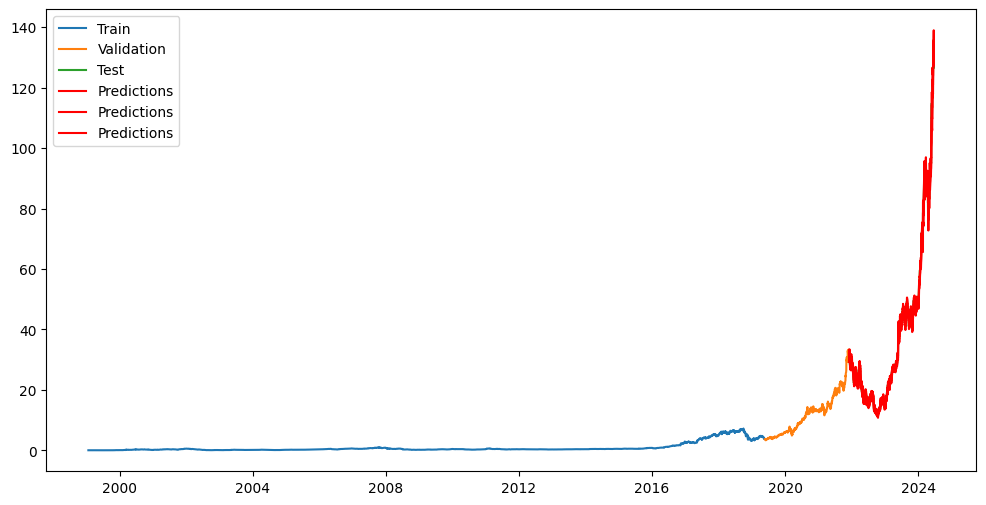

In [86]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(val.index, val['Close'], label='Validation')
plt.plot(test.index, test['Close'], label='Test')
plt.plot(forecast_df.index, forecast_df['Predictions'], label='Predictions', color='r')
plt.plot(forecast_df.index, forecast_df['Lower Bound'], label='Predictions', color='r')
plt.plot(forecast_df.index, forecast_df['Upper Bound'], label='Predictions', color='r')
plt.fill_between(forecast_df.index, forecast_df['Lower Bound'], forecast_df['Upper Bound'], color='pink', alpha=0.3)
plt.legend(loc='upper left')
plt.show()

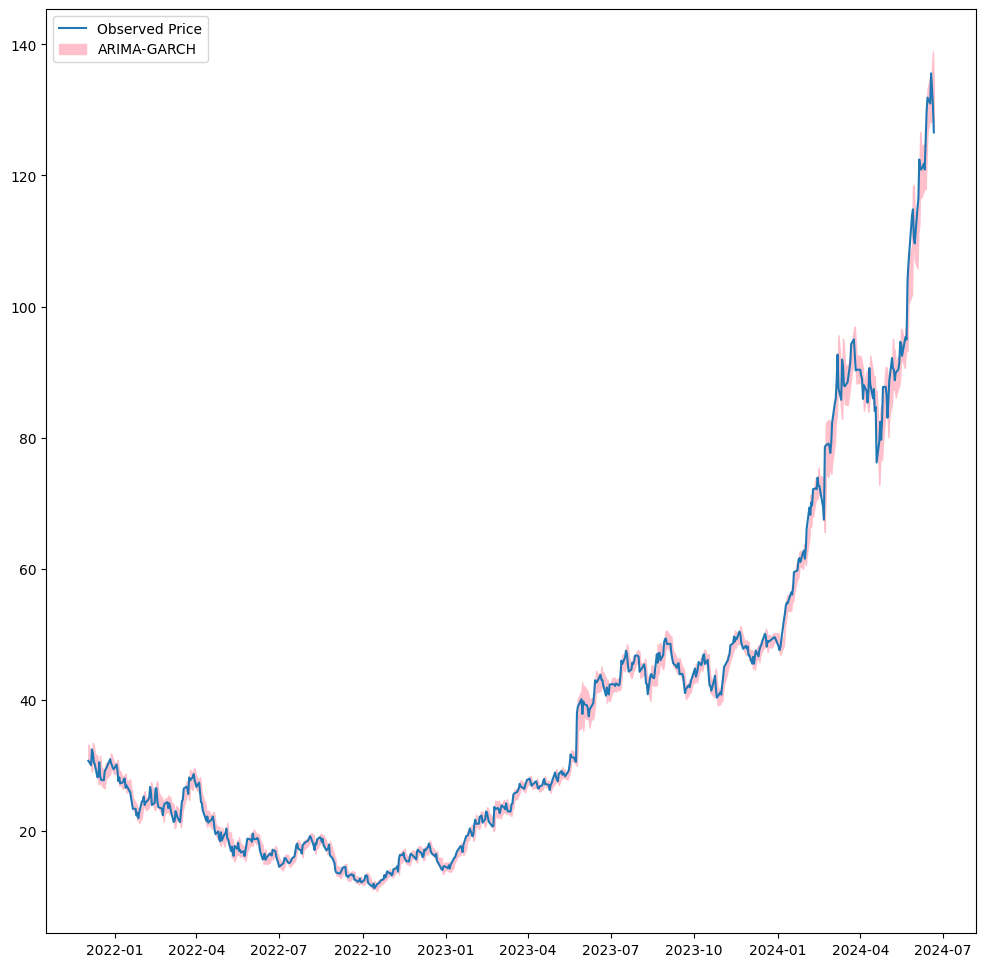

In [97]:
plt.figure(figsize=(12, 12))
plt.plot(test.index, test['Close'], label='Observed Price')
#plt.plot(forecast_df.index, forecast_df['Predictions'], label='Predictions', color='r')
#plt.plot(forecast_df.index, forecast_df['Lower Bound'], label='Predictions', color='r')
#plt.plot(forecast_df.index, forecast_df['Upper Bound'], label='Predictions', color='r')
plt.fill_between(forecast_df.index, forecast_df['Lower Bound'], forecast_df['Upper Bound'], color='pink', alpha=1, label="ARIMA-GARCH")
plt.legend(loc='upper left')
plt.show()

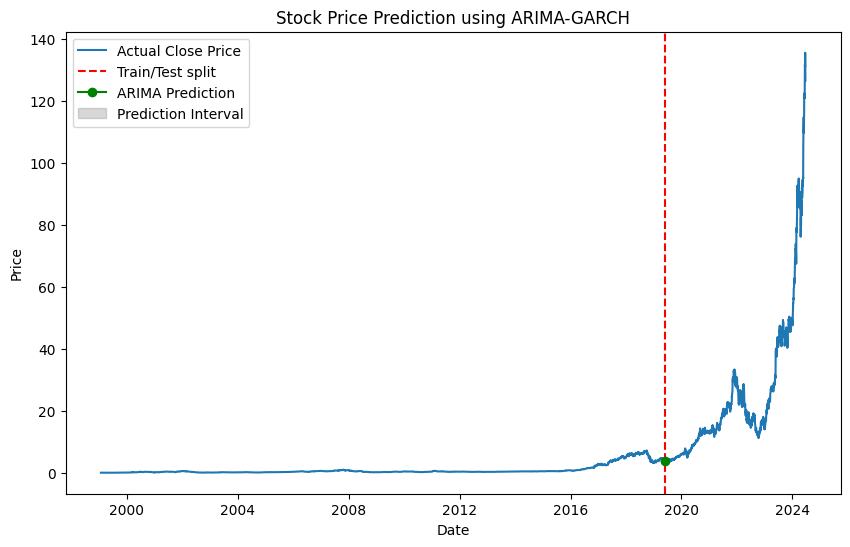

In [89]:
plt.figure(figsize=(10, 6))
plt.plot(df['Close'], label='Actual Close Price')
plt.axvline(df.index[train_size], color='r', linestyle='--', label='Train/Test split')
plt.plot(pd.Series(arima_pred.iloc[0], index=[df.index[train_size]]), color='g', marker='o', label='ARIMA Prediction')
plt.fill_between([df.index[train_size]], arima_garch_lower.iloc[0], arima_garch_upper.iloc[0], color='gray', alpha=0.3, label='Prediction Interval')
plt.legend()
plt.title('Stock Price Prediction using ARIMA-GARCH')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()